<a href="https://colab.research.google.com/github/maurermi/EECE5644-Final-Project-FINAL-DRAFT/blob/main/ML_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import pandas as pd

import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import SpatialDropout1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import TextVectorization
from keras import layers

import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn import metrics

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

# Import Data

In [3]:
np.random.seed(40)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
colab = 'colab'
local = 'local'
env = colab
#env = local

In [5]:
if env == colab:
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/My Drive/eece5644_final_project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_df = pd.read_csv(data_path + 'tamil_movie_reviews_train.csv')
test_df = pd.read_csv(data_path + 'tamil_movie_reviews_test.csv')

In [7]:
train_df = train_df.drop_duplicates().reset_index(drop=True)
test_df = test_df.drop_duplicates().reset_index(drop=True)

# Preprocess

In [8]:
#binary split
def binary_split(y):
  mid_point = 7
  y_mini = y.copy()
  for i in range(len(y_mini)):
    if y[i] <= mid_point:
      y_mini[i] = 0
    else:
      y_mini[i] = 1
  return y_mini

In [9]:
def tertiary_split(y):
  lower_bound = 6
  upper_bound = 8
  y_mini = y.copy()
  for i in range(len(y_mini)):
    if y[i] <= lower_bound:
      y_mini[i] = 0
    elif lower_bound < y[i] <= upper_bound:
      y_mini[i] = 1
    elif upper_bound < y[i]:
      y_mini[i] = 2
  return y_mini

In [10]:
def polarize(x, y):
  lower_bound = 6
  upper_bound = 8
  y_mini = y.copy()
  x_new = np.array([])
  y_mini_new = np.array([])
  for i in range(len(y_mini)):
    if y[i] <= lower_bound:
      x_new = np.append(x_new, x[i])
      y_mini_new = np.append(y_mini_new, 0)
    elif upper_bound < y[i]:
      x_new = np.append(x_new, x[i])
      y_mini_new = np.append(y_mini_new, 1)
  return x_new, y_mini_new

In [11]:
# Ratings are given in increments of 0.25, so let's just normalize them
df = pd.concat([train_df, test_df], ignore_index=True)

df.Rating = df.Rating * 4 - 4
df.Rating = df.Rating.astype(int)

In [12]:
# Cite ChatGPT
def read_stop_words(filename):
    stop_words = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            stop_words.append(line.strip())
    return stop_words

filename = data_path + "TamilStopWords.txt"
stop_words_list = read_stop_words(filename)

In [13]:
def create_vectorizer(stop_words):
  return TfidfVectorizer(stop_words = stop_words)

In [14]:
def vectorize_tamil_data():
  filename = data_path + "TamilStopWords.txt"
  stop_words_list = read_stop_words(filename)

  vectorizer = create_vectorizer(stop_words = stop_words_list)

  X = vectorizer.fit_transform(df.ReviewInTamil).toarray()
  y = df.Rating

  return (X, y)


In [15]:
def vectorize_english_data():
  pass

In [16]:
vectorizer = create_vectorizer(stop_words = 'english')

# vectorizer = TfidfVectorizer(stop_words = 'english')
#vectorizer = TextVectorization()

In [17]:
X, y = vectorize_tamil_data()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.
  warnings.warn(


In [18]:
num_features = X.shape[1]
print("Total number of features:", num_features)

Total number of features: 2589


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [20]:
max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

# Evaluation



In [21]:
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_curve, precision_recall_fscore_support, roc_auc_score, roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import time

def evaluate_model(y_true, x_test, clf, round=False, dim=3):
  '''
  y_true: true class labels for test data
  x_test: test data features
  clf: model to evaluate
  '''
  y_pred = clf.predict(x_test)
  if(round):
    y_pred = np.round(y_pred)
  report = classification_report(y_true, y_pred, output_dict=True)
  print(classification_report(y_true, y_pred))
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  for c in range(0, dim):
    #print(f'Class: {c}')
    # precision = report[str(c)]['precision']
    # recall = report[str(c)]['recall']
    predictions = []
    gold = []
    for i in y_pred:
      if i == c:
        predictions.append(0)
      else:
        predictions.append(1)
    for i in y_true:
      if i == c:
        gold.append(0)
      else:
        gold.append(1)
    PrecisionRecallDisplay.from_predictions(gold, predictions, name = f'Precison/Recall, class {str(c)}')
    RocCurveDisplay.from_predictions(gold, predictions, name = f'ROC, class {str(c)}')
    inference_times = []
  for sample in x_test:
    temp_array = [sample]
    start_time = time.time()
    clf.predict(temp_array)
    end_time = time.time()
    inference_times.append(end_time - start_time)
  fig = px.box(inference_times)
  fig.show()

def compute_inference_times(y_true, x_test, clf, round=False, dim=3):
  '''
  y_true: true class labels for test data
  x_test: test data features
  clf: model to evaluate
  '''
  inference_times = []
  print(x_test)
  print(type(x_test))
  print(x_test.shape)
  for sample in x_test:
    temp_array = [sample]
    print(temp_array)
    print(sample)
    print(type(temp_array))
    print(type(sample))
    start_time = time.time()
    clf.predict(temp_array)
    end_time = time.time()
    inference_times.append(end_time - start_time)
  fig = px.box(inference_times)
  fig.show()

# Bayes

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.45      0.49        44
           1       0.54      0.61      0.57        46
           2       0.47      0.48      0.48        31

    accuracy                           0.52       121
   macro avg       0.52      0.52      0.51       121
weighted avg       0.52      0.52      0.52       121



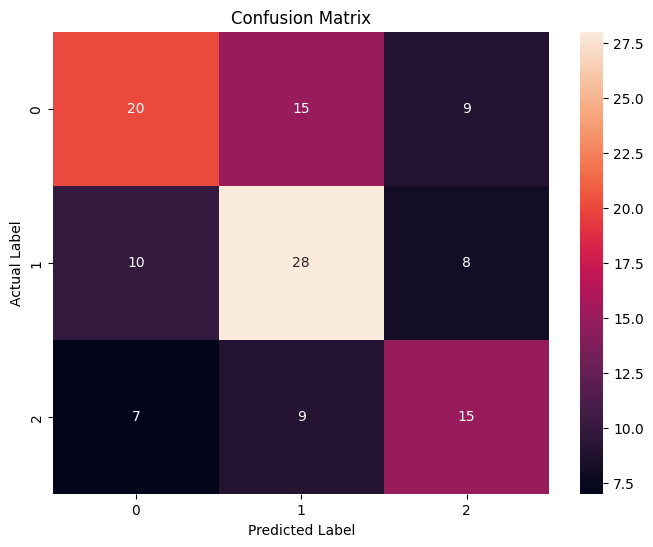

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        72
           1       0.64      0.69      0.67        49

    accuracy                           0.72       121
   macro avg       0.71      0.71      0.71       121
weighted avg       0.72      0.72      0.72       121



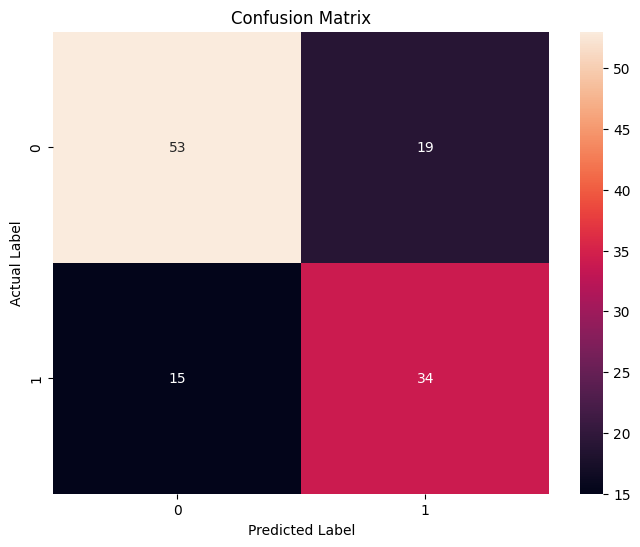

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

model = GaussianNB()

y_mini = tertiary_split(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)

model.fit(X_train, y_train)

tertiary_bayes_model = model

y_pred = model.predict(X_test)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

y_mini = binary_split(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)

model.fit(X_train, y_train)

binary_bayes_model = model

y_pred = model.predict(X_test)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(stop_words_list)
print(df.ReviewInTamil)

['ஒரு', 'என்று', 'மற்றும்', 'இந்த', 'இது', 'என்ற', 'கொண்டு', 'என்பது', 'பல', 'ஆகும்', 'அல்லது', 'அவர்', 'நான்', 'உள்ள', 'அந்த', 'இவர்', 'என', 'முதல்', 'என்ன', 'இருந்து', 'சில', 'என்', 'போன்ற', 'வேண்டும்', 'வந்து', 'இதன்', 'அது', 'அவன்', 'தான்', 'பலரும்', 'என்னும்', 'மேலும்', 'பின்னர்', 'கொண்ட', 'இருக்கும்', 'தனது', 'உள்ளது', 'போது', 'என்றும்', 'அதன்', 'தன்', 'பிறகு', 'அவர்கள்', 'வரை', 'அவள்', 'நீ', 'ஆகிய', 'இருந்தது', 'உள்ளன', 'வந்த', 'இருந்த', 'மிகவும்', 'இங்கு', 'மீது', 'ஓர்', 'இவை', 'இந்தக்', 'பற்றி', 'வரும்', 'வேறு', 'இரு', 'இதில்', 'போல்', 'இப்போது', 'அவரது', 'மட்டும்', 'இந்தப்', 'எனும்', 'மேல்', 'பின்', 'சேர்ந்த', 'ஆகியோர்', 'எனக்கு', 'இன்னும்', 'அந்தப்', 'அன்று', 'ஒரே', 'மிக', 'அங்கு', 'பல்வேறு', 'விட்டு', 'பெரும்', 'அதை', 'பற்றிய', 'உன்', 'அதிக', 'அந்தக்', 'பேர்', 'இதனால்', 'அவை', 'அதே', 'ஏன்', 'முறை', 'யார்', 'என்பதை', 'எல்லாம்', 'மட்டுமே', 'இங்கே', 'அங்கே', 'இடம்', 'இடத்தில்', 'அதில்', 'நாம்', 'அதற்கு', 'எனவே', 'பிற', 'சிறு', 'மற்ற', 'விட', 'எந்த', 'எனவும்', 'எனப்படும்', 'எனி

# k-NN


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.



Rating
Neutral     229
Negative    222
Positive    150
Name: count, dtype: int64
Neutral     53
Negative    41
Positive    27
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.53      0.59        51
     Neutral       0.53      0.70      0.60        40
    Positive       0.63      0.57      0.60        30

    accuracy                           0.60       121
   macro avg       0.61      0.60      0.60       121
weighted avg       0.61      0.60      0.59       121



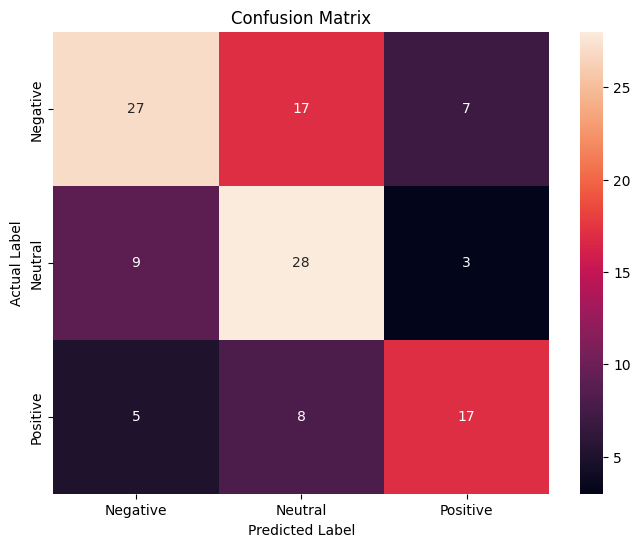

Rating
Negative    313
Positive    288
Name: count, dtype: int64
Negative    64
Positive    57
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.70      0.72        69
    Positive       0.63      0.69      0.66        52

    accuracy                           0.69       121
   macro avg       0.69      0.69      0.69       121
weighted avg       0.70      0.69      0.70       121



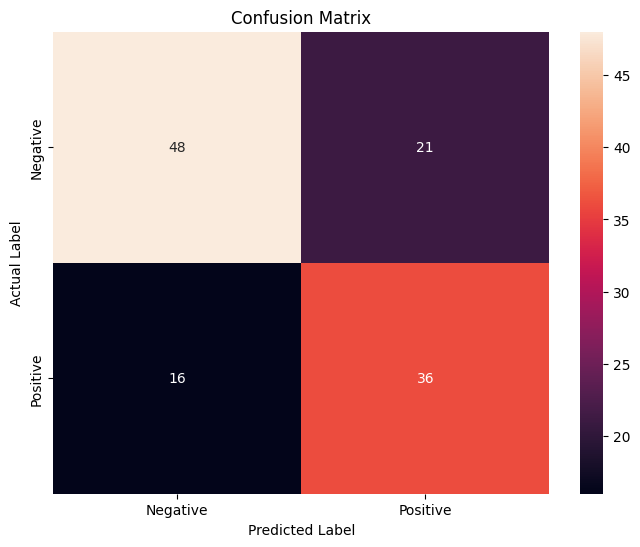

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# load data from csv files
train_data = pd.read_csv(data_path + 'tamil_movie_reviews_train.csv')
test_data = pd.read_csv(data_path + 'tamil_movie_reviews_test.csv')

# merge train and test data together
df = pd.concat([train_data, test_data], ignore_index = True)

# assign intelligible rating values for every rating in df
min_rating = 1.0
max_rating = 4.50
alpha = 0.25
i = 0

# dictionary to map ratings to ints
df.Rating = df.Rating * 4 - 4
df.Rating = df.Rating.astype(int)

# convert text data into numerical features using CountVectorizer
X, y = vectorize_tamil_data()

## Ternary Model
# convert ratings into categorical labels: negative, neutral, and positive
neg_bound = 6
pos_bound = 8
y_categories = y.copy()
for i in range(len(y_categories)):
    if y_categories[i] <= neg_bound:
        y_categories[i] = 'Negative'
    elif neg_bound < y_categories[i] <= pos_bound:
        y_categories[i] = 'Neutral'
    elif y_categories[i] > pos_bound:
        y_categories[i] = 'Positive'
print(y_categories.value_counts())

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categories, test_size=0.2, random_state = 0)

# neighbor values to check
neighbors = list(range(1, 51))
optimal_accuracy = 0
optimal_neighbors = 0

# loop through different neighbor values and choose value with highest accuracy
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > optimal_accuracy:
        optimal_accuracy = accuracy
        optimal_neighbors = n

# train KNN model
knn = KNeighborsClassifier(n_neighbors = optimal_neighbors)
knn.fit(X_train, y_train)

knn_tertiary_model = knn

# predict sentiment labels from test data
y_pred = knn.predict(X_test)
y_pred_series = pd.Series(y_pred)
print(y_pred_series.value_counts())

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

## Binary Model
# convert ratings into categorical labels: negative, neutral, and positive
bound = 7
y_categories = y.copy()
for i in range(len(y_categories)):
    if y_categories[i] <= bound:
        y_categories[i] = 'Negative'
    elif y_categories[i] > bound:
        y_categories[i] = 'Positive'
print(y_categories.value_counts())

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categories, test_size=0.2, random_state = 0)

# neighbor values to check
neighbors = list(range(1, 51))
optimal_accuracy = 0
optimal_neighbors = 0

# loop through different neighbor values and choose value with highest accuracy
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > optimal_accuracy:
        optimal_accuracy = accuracy
        optimal_neighbors = n

# train KNN model
knn = KNeighborsClassifier(n_neighbors = optimal_neighbors)
knn.fit(X_train, y_train)

knn_binary_model = knn


# predict sentiment labels from test data
y_pred = knn.predict(X_test)
y_pred_series = pd.Series(y_pred)
print(y_pred_series.value_counts())

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# SVM - Linear Kernel

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.



Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        45
           1       0.47      0.68      0.55        40
           2       0.62      0.22      0.33        36

    accuracy                           0.54       121
   macro avg       0.56      0.52      0.50       121
weighted avg       0.56      0.54      0.51       121



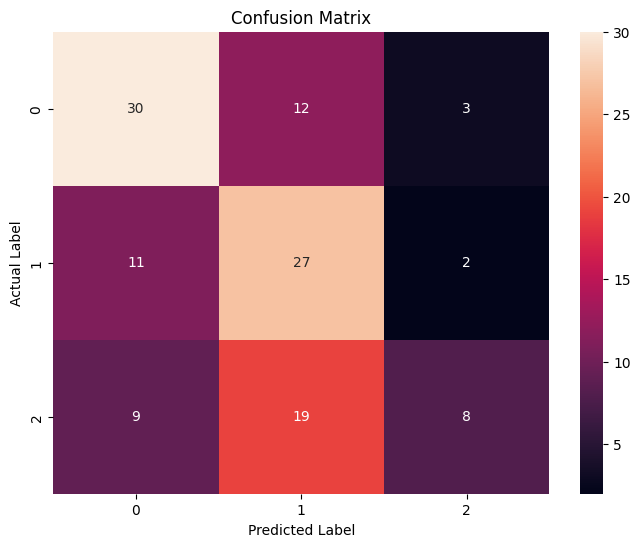

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67        59
           1       0.68      0.69      0.69        62

    accuracy                           0.68       121
   macro avg       0.68      0.68      0.68       121
weighted avg       0.68      0.68      0.68       121



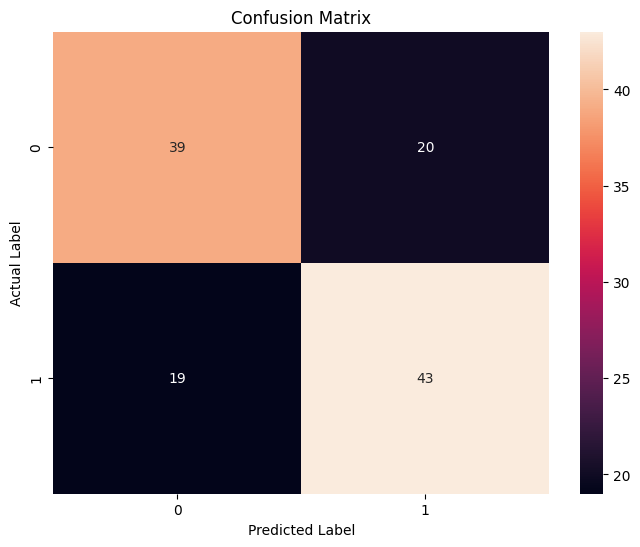

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

# Read the data
train_df = pd.read_csv(data_path + 'tamil_movie_reviews_train.csv')
test_df = pd.read_csv(data_path + 'tamil_movie_reviews_test.csv')

# Remove duplicates from the data
train_df = train_df.drop_duplicates().reset_index(drop=True)
test_df = test_df.drop_duplicates().reset_index(drop=True)

# Ratings are given in increments of 0.25, so let's just normalize them
df = pd.concat([train_df, test_df], ignore_index=True)

df.Rating = df.Rating * 4 - 4
df.Rating = df.Rating.astype(int)

# Convert Rating column to integer type
df.Rating = df.Rating.astype(int)

# TF-IDF Vectorization
X, y = vectorize_tamil_data()


y_mini = tertiary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
# Initialize and train the SVM classifier with Linear kernel
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

tertiary_linear_svm_classifier = svm_classifier
# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()



y_mini = binary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
# Initialize and train the SVM classifier with Linear kernel
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

binary_linear_svm_classifier = svm_classifier


# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

#SVM - Polynomial Kernel

In [ ]:
#polynomial Kernel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

# Set random seed for reproducibility
np.random.seed(44)

# Download stopwords from NLTK
nltk.download('stopwords')

# Read the data
train_df = pd.read_csv(data_path + 'tamil_movie_reviews_train.csv')
test_df = pd.read_csv(data_path + 'tamil_movie_reviews_test.csv')

# Remove duplicates from the data
train_df = train_df.drop_duplicates().reset_index(drop=True)
test_df = test_df.drop_duplicates().reset_index(drop=True)

# Concatenate train and test data for preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)

df.Rating = df.Rating * 4 - 4
df.Rating = df.Rating.astype(int)

# TF-IDF Vectorization
X, y = vectorize_tamil_data()

y_mini = tertiary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)

# Initialize and train the SVM classifier with polynomial kernel
svm_classifier = SVC(kernel='poly', degree=3)  # Set degree to the desired degree of the polynomial
svm_classifier.fit(X_train, y_train)

tertiary_poly_svm_classifier = svm_classifier

y_mini = binary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
# Initialize and train the SVM classifier with Linear kernel
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train, y_train)

binary_poly_svm_classifier = svm_classifier

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

#SVM - RBF Kernel

In [ ]:
#RBF Kernel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

# Set random seed for reproducibility
np.random.seed(44)

# Download stopwords from NLTK
nltk.download('stopwords')

# Read the data
train_df = pd.read_csv(data_path + 'tamil_movie_reviews_train.csv')
test_df = pd.read_csv(data_path + 'tamil_movie_reviews_test.csv')

# Remove duplicates from the data
train_df = train_df.drop_duplicates().reset_index(drop=True)
test_df = test_df.drop_duplicates().reset_index(drop=True)

# Concatenate train and test data for preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)

df.Rating = df.Rating * 4 - 4
df.Rating = df.Rating.astype(int)

# TF-IDF Vectorization
X, y = vectorize_tamil_data()

y_mini = tertiary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)

# Initialize and train the SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)

tertiary_rbf_svm_classifier = svm_classifier

y_mini = binary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
# Initialize and train the SVM classifier with Linear kernel
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)

binary_rbf_svm_classifier = svm_classifier

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

#SVM - Sigmoid Kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

# Set random seed for reproducibility
np.random.seed(44)

# Download stopwords from NLTK
nltk.download('stopwords')

# Read the data
train_df = pd.read_csv(data_path + 'tamil_movie_reviews_train.csv')
test_df = pd.read_csv(data_path + 'tamil_movie_reviews_test.csv')

# Remove duplicates from the data
train_df = train_df.drop_duplicates().reset_index(drop=True)
test_df = test_df.drop_duplicates().reset_index(drop=True)

# Concatenate train and test data for preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)

df.Rating = df.Rating * 4 - 4
df.Rating = df.Rating.astype(int)

# TF-IDF Vectorization
X, y = vectorize_tamil_data()

y_mini = tertiary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)

# Initialize and train the SVM classifier with Sigmoid kernel
svm_classifier = SVC(kernel='sigmoid')
svm_classifier.fit(X_train, y_train)

tertiary_sigmoid_svm_classifier = svm_classifier

y_mini = binary_split(y)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
# Initialize and train the SVM classifier with Linear kernel
svm_classifier = SVC(kernel='sigmoid')
svm_classifier.fit(X_train, y_train)

binary_sigmoid_svm_classifier = svm_classifier

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# PCA

In [45]:
X, y = vectorize_tamil_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.
  warnings.warn(


In [46]:
fig = px.histogram(y)
# fig.show()

In [47]:
y_mini = tertiary_split(y)
y_mini.value_counts()

Rating
1    229
0    222
2    150
Name: count, dtype: int64

In [48]:
fig = px.histogram(y_mini)
# fig.show()

In [49]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)
X_pca = components

In [50]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

In [51]:
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_mini,
    title=f'pca',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [52]:
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(0, 3),
    color=y_mini
)
fig.update_traces(diagonal_visible=False)
fig.show()

# Cluster

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_mini, test_size=.20)
# np.random.seed(40)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)

    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_train.shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [54]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.20266406846972232
2 : 0.16839925212732126
3 : 0.11260841901697574
4 : 0.09637747541036196
5 : 0.09086072520490523
6 : 0.08259646768086266
7 : 0.07517581190219537
8 : 0.07029014247582054
9 : 0.06621290319073891


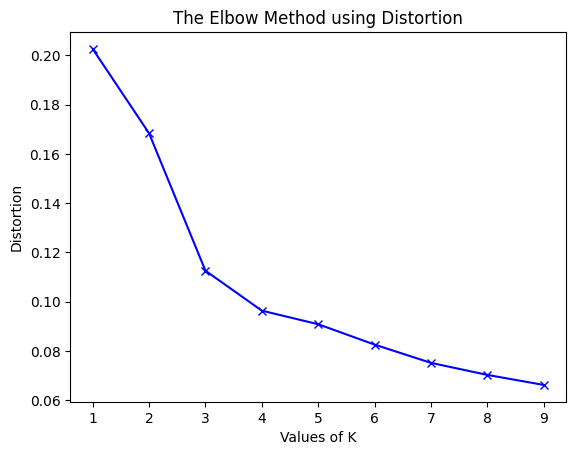

In [55]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [56]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 27.705859270820905
2 : 15.845827117367046
3 : 8.406307890672238
4 : 6.00286171227024
5 : 5.105248132994017
6 : 4.243772593142145
7 : 3.470189104917189
8 : 3.104075907840977
9 : 2.795997173165959


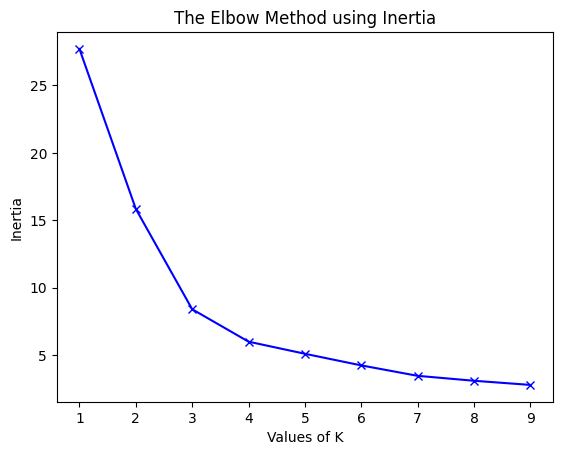

In [57]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [58]:
# Specify the number of clusters (k)
k = 3

# Initialize K-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_train)

# Get the cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [59]:
# Create a DataFrame with cluster labels and 3D coordinates
df_plot = pd.DataFrame(X_train, columns=['Feature 1', 'Feature 2', 'Feature 3'])
df_plot['Cluster'] = cluster_labels.astype(str)  # Convert cluster labels to string for categorical coloring

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(df_plot, x='Feature 1', y='Feature 2', z='Feature 3', color='Cluster',
                    title='K-means Clustering in 3D', opacity=0.7)


# Set layout parameters for the 3D plot
fig.update_layout(scene=dict(
                    xaxis_title='Feature 1',
                    yaxis_title='Feature 2',
                    zaxis_title='Feature 3'))

# Show the 3D plot
fig.show()


In [60]:
score = metrics.accuracy_score(y_train,kmeans.predict(X_train))
score

0.2708333333333333

              precision    recall  f1-score   support

           0       0.48      0.41      0.44        49
           1       0.11      0.02      0.04        47
           2       0.23      0.64      0.34        25

    accuracy                           0.31       121
   macro avg       0.27      0.36      0.27       121
weighted avg       0.28      0.31      0.26       121



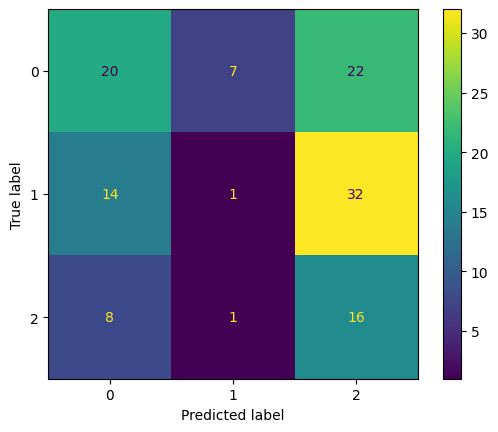

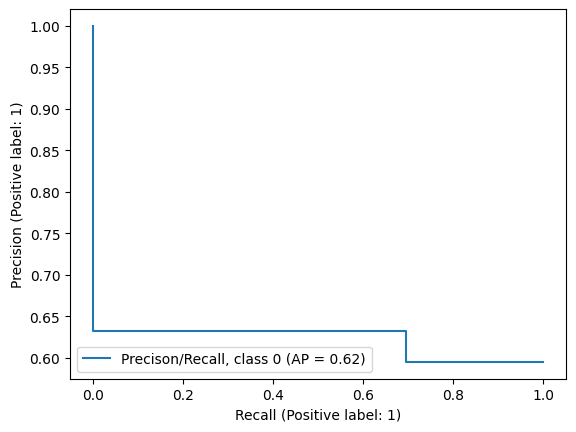

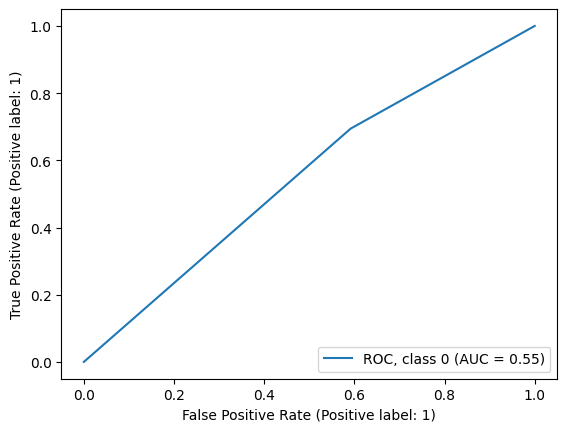

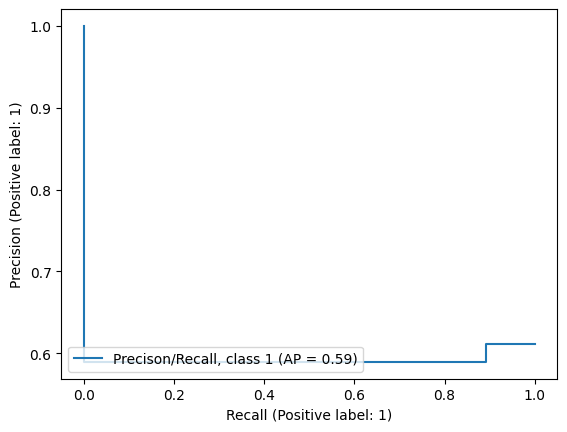

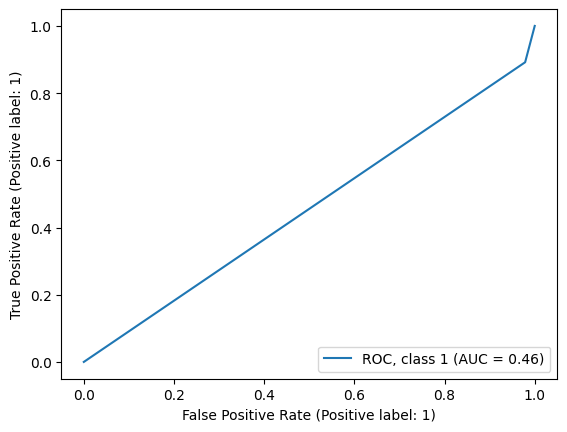

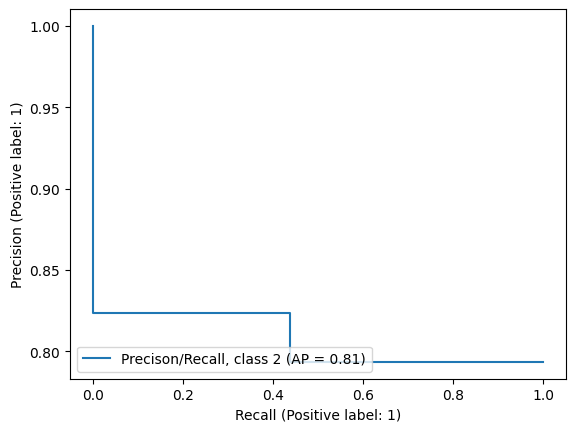

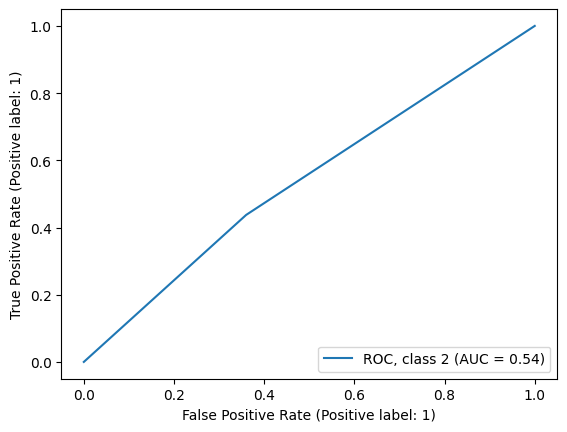

In [61]:
evaluate_model(y_test, X_test, kmeans)

# PCA (Binary)

In [62]:
X, y = vectorize_tamil_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.



In [63]:
fig = px.histogram(y)
# fig.show()

In [64]:
y_mini = binary_split(y)
y_mini.value_counts()

Rating
0    313
1    288
Name: count, dtype: int64

In [65]:
fig = px.histogram(y_mini)
# fig.show()

In [66]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)
X_pca = components

In [67]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

In [68]:
fig = px.scatter(
    components, x=0, y=1, color=y_mini,
    title=f'pca',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [69]:
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(0, 2),
    color=y_mini
)
fig.update_traces(diagonal_visible=False)
fig.show()

# Cluster (Binary)

In [70]:
np.random.seed(40)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_mini, test_size=.20)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)

    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_train.shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [71]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.16805165960308413
2 : 0.13174388629124523
3 : 0.06462934510239028
4 : 0.0533530872916
5 : 0.04895473702027111
6 : 0.043137614736259836
7 : 0.037133991619132126
8 : 0.034356168955591494
9 : 0.032968553660480716


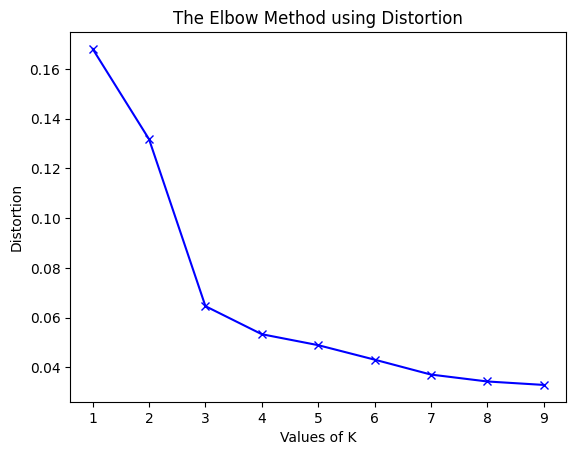

In [72]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [73]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 21.923809317798273
2 : 10.455714051589958
3 : 3.136867996678668
4 : 2.3135907921849057
5 : 1.6417724476971478
6 : 1.269421832198756
7 : 1.0174438403256514
8 : 0.806289147101342
9 : 0.700896585220337


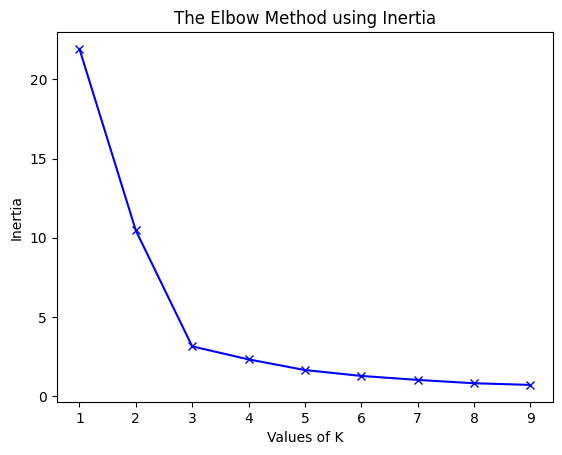

In [74]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [75]:
# Specify the number of clusters (k)
k = 2

# Initialize K-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_train)

# Get the cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [76]:
# Create a DataFrame with cluster labels and 3D coordinates
df_plot = pd.DataFrame(X_train, columns=['Feature 1', 'Feature 2'])
df_plot['Cluster'] = cluster_labels.astype(str)  # Convert cluster labels to string for categorical coloring

# Create a 3D scatter plot using Plotly Express
fig = px.scatter(df_plot, x='Feature 1', y='Feature 2', color='Cluster',
                    title='K-means Clustering in 3D', opacity=0.7)


# Set layout parameters for the 3D plot
fig.update_layout(scene=dict(
                    xaxis_title='Feature 1',
                    yaxis_title='Feature 2'))

# Show the 3D plot
fig.show()


In [77]:
score = metrics.accuracy_score(y_test,kmeans.predict(X_test))
score

0.4628099173553719

              precision    recall  f1-score   support

           0       0.46      0.89      0.61        57
           1       0.45      0.08      0.13        64

    accuracy                           0.46       121
   macro avg       0.46      0.49      0.37       121
weighted avg       0.46      0.46      0.36       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless



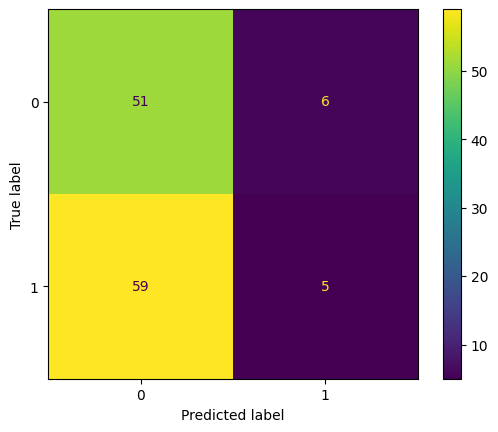

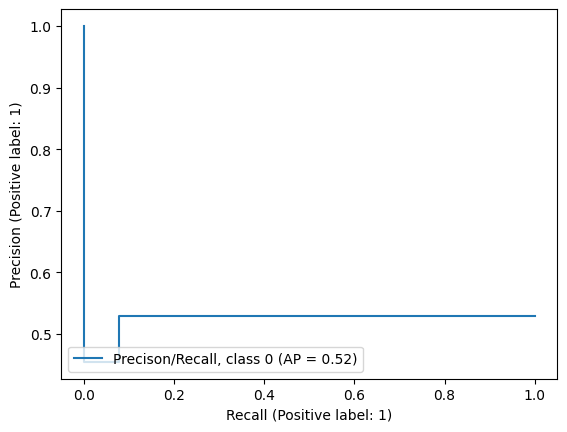

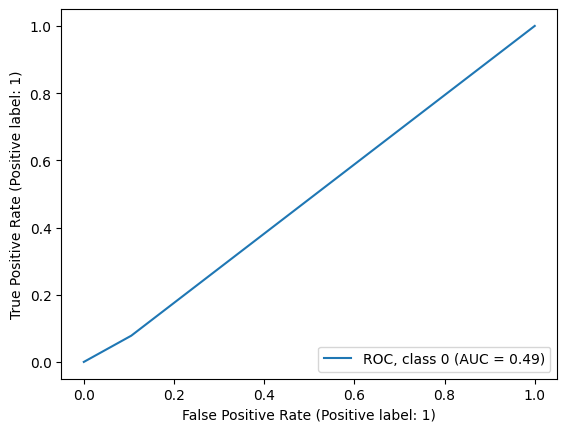

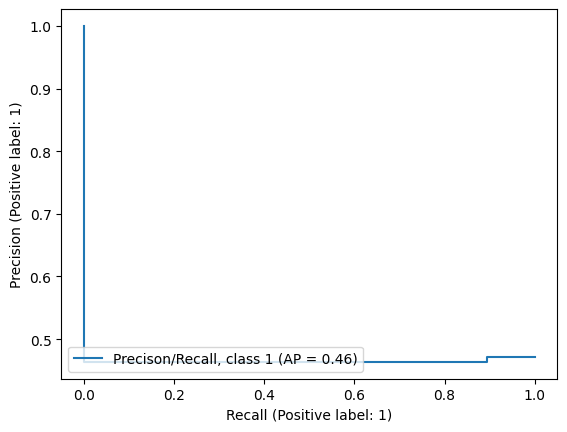

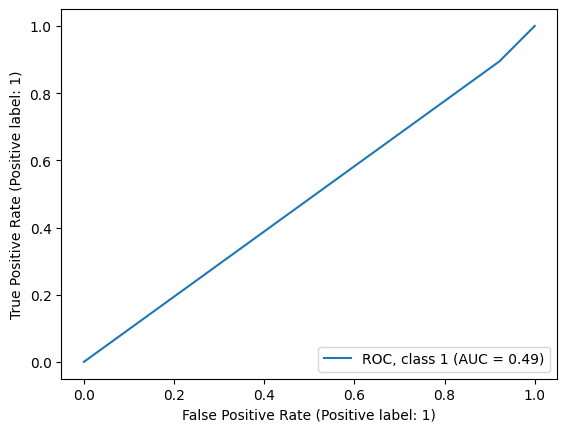

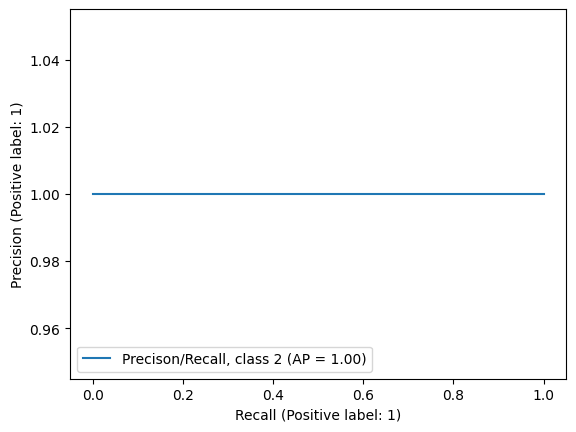

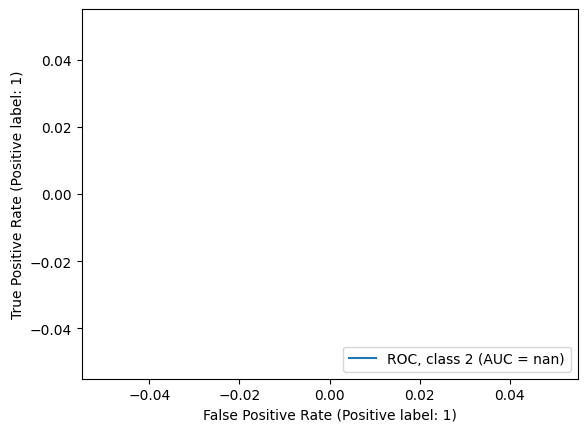

In [78]:
evaluate_model(y_test, X_test, kmeans)

# LSTM | Neural Net

In [79]:
max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

In [80]:
def save(model):
  # Save the model
  model.save('/content/drive/My Drive/eece5644_final_project/lstm_model.keras')

def load():
  return keras.models.load_model('/content/drive/My Drive/eece5644_final_project/lstm_model.keras')

In [81]:
def eval(model, x_test, y_test, batch_size=32):
  y_pred = model.predict(x_test)
  # classification report
  report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(report)

  # confusion matrix
  plt.figure(figsize=(8, 6))
  conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
  sns.heatmap(conf_matrix, annot=True, fmt='d')
  plt.title('Confusion Matrix')
  plt.show()


In [82]:
# Code based off of this: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

y_mini = tertiary_split(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss="categorical_crossentropy", metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2757761 (10.52 MB)
Trainable params: 2757761 (1

In [ ]:
# PLEASE DON'T RUN COSTS GPU
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))
model.save('/content/drive/My Drive/eece5644_final_project/tertiary_lstm_model.keras')

In [83]:
# Code based off of this: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

y_mini = binary_split(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss="binary_crossentropy", metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2757761 (10.52 MB)
Trainable params: 2757761 

In [ ]:
# PLEASE DON'T RUN COSTS GPU
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))
model.save('/content/drive/My Drive/eece5644_final_project/binary_lstm_model.keras')

# English Preprocessing

In [174]:
# https://keras.io/api/datasets/imdb/

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=max_features
)
# Use pad_sequence to standardize sequence length:
# this will truncate sequences longer than 200 words and zero-pad sequences shorter than 200 words.
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

# English Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.64      0.57     12500
           1       0.52      0.38      0.44     12500

    accuracy                           0.51     25000
   macro avg       0.51      0.51      0.50     25000
weighted avg       0.51      0.51      0.50     25000



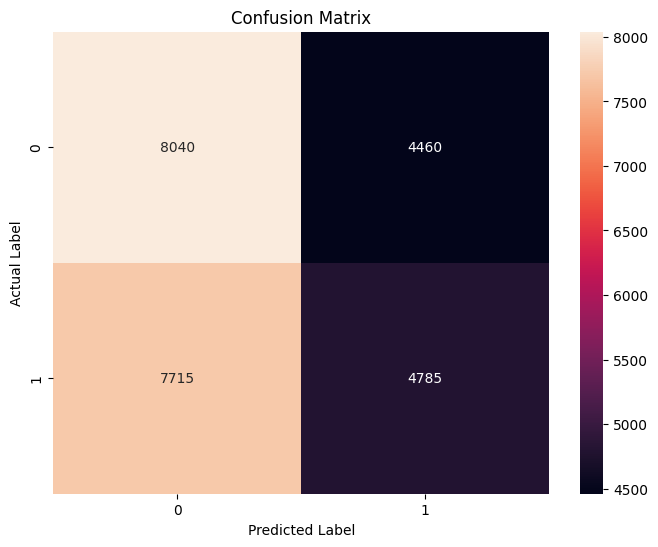

In [175]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

model = GaussianNB()

model.fit(x_train, y_train)

english_bayes_model = model

y_pred = model.predict(x_test)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# k-NN on English Data

0    16273
1     8727
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.66      0.57     12500
           1       0.51      0.36      0.42     12500

    accuracy                           0.51     25000
   macro avg       0.51      0.51      0.50     25000
weighted avg       0.51      0.51      0.50     25000



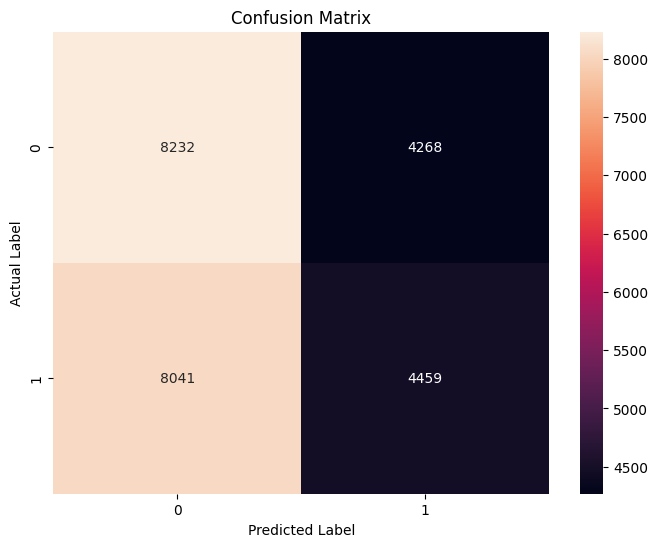

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# neighbor values to check
neighbors = list(range(1, 51))
optimal_accuracy = 0
optimal_neighbors = 0

# loop through different neighbor values and choose value with highest accuracy
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > optimal_accuracy:
        optimal_accuracy = accuracy
        optimal_neighbors = n

# train KNN model
knn = KNeighborsClassifier(n_neighbors = optimal_neighbors)
knn.fit(x_train, y_train)

english_knn_classifier = knn

# predict sentiment labels from test data
y_pred = knn.predict(x_test)
y_pred_series = pd.Series(y_pred)
print(y_pred_series.value_counts())

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# SVM on English Data

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Initialize and train the SVM classifier with Sigmoid kernel
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = svm_classifier.predict(x_test)

english_svm_classifier = svm_classifier

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Label'], colnames=['Predicted Label'])
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# LSTM on English Data

In [ ]:
# CODE TAKEN FROM: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
print(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))

In [ ]:
model.save('/content/drive/My Drive/eece5644_final_project/english_lstm_model.keras')

# PCA | English

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=max_features
)
# Use pad_sequence to standardize sequence length:
# this will truncate sequences longer than 200 words and zero-pad sequences shorter than 200 words.
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(x_train)
X_pca = components

In [ ]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

In [ ]:
fig = px.scatter(
    components, x=0, y=1, color=y_train,
    title=f'pca',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [ ]:
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(0, 2),
    color=y_train
)
fig.update_traces(diagonal_visible=False)
fig.show()

# K-Means | English

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_train, test_size=.20)
np.random.seed(40)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)

    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_train.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
# Specify the number of clusters (k)
k = 2

# Initialize K-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_train)

# Get the cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [ ]:
# Create a DataFrame with cluster labels and 3D coordinates
df_plot = pd.DataFrame(X_train, columns=['Feature 1', 'Feature 2'])
df_plot['Cluster'] = cluster_labels.astype(str)  # Convert cluster labels to string for categorical coloring

# Create a 3D scatter plot using Plotly Express
fig = px.scatter(df_plot, x='Feature 1', y='Feature 2', color='Cluster',
                    title='K-means Clustering in 3D', opacity=0.7)


# Set layout parameters for the 3D plot
fig.update_layout(scene=dict(
                    xaxis_title='Feature 1',
                    yaxis_title='Feature 2'))

# Show the 3D plot
fig.show()


In [ ]:
score = metrics.accuracy_score(y_train,kmeans.predict(X_train))
score

In [ ]:
evaluate_model(y_test, X_test, kmeans)

# Evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.



Evaluating tertiary bayes model
              precision    recall  f1-score   support

           0       0.65      0.93      0.77        46
           1       0.38      0.51      0.44        41
           2       0.00      0.00      0.00        34

    accuracy                           0.53       121
   macro avg       0.34      0.48      0.40       121
weighted avg       0.38      0.53      0.44       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

Evaluating tertiary SVM model
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        46
           1       0.71      0.88      0.78        41
           2       0.95      0.53      0.68        34

    accuracy                           0.77       121
   macro avg       0.81      0.75      0.76       121
weighted avg       0.80      0.77      0.76       121



Evaluating tertiary kNN model
              precision    recall  f1-score   support

    Negative       0.92      0.88      0.90        40
     Neutral       0.85      0.93      0.89        43
    Positive       0.94      0.89      0.92        38

    accuracy                           0.90       121
   macro avg       0.91      0.90      0.90       121
weighted avg       0.90      0.90      0.90       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/roc_curve.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



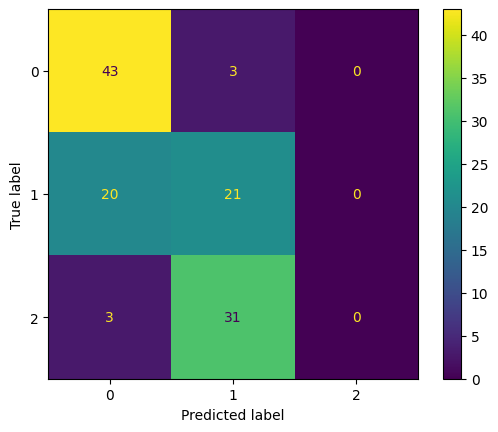

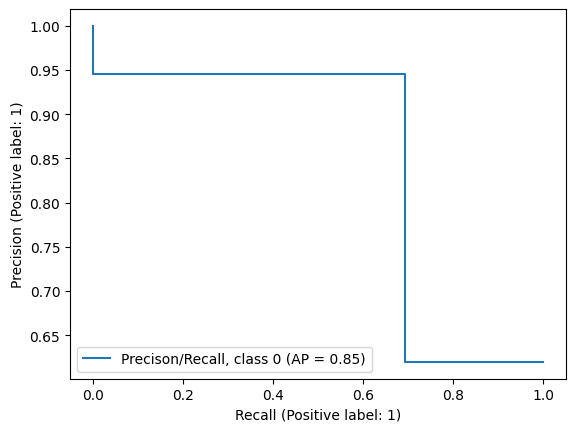

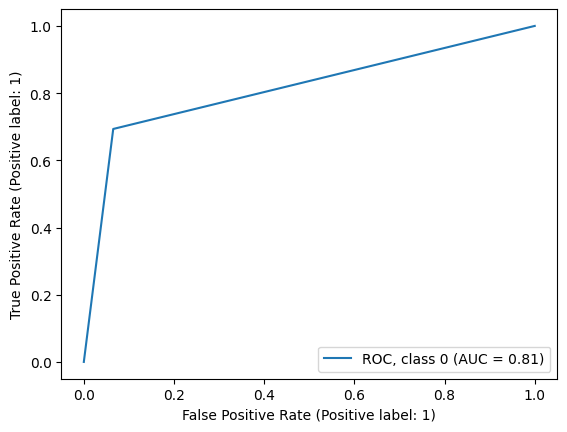

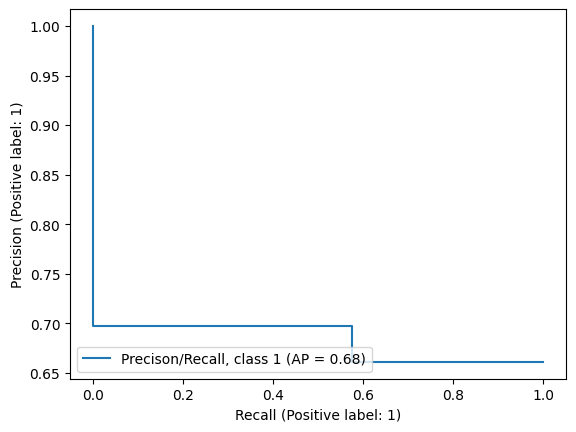

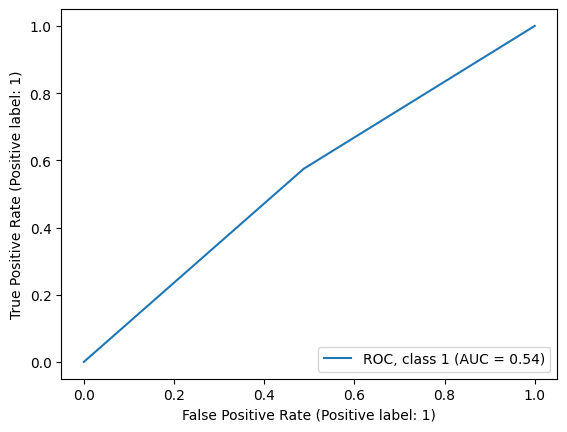

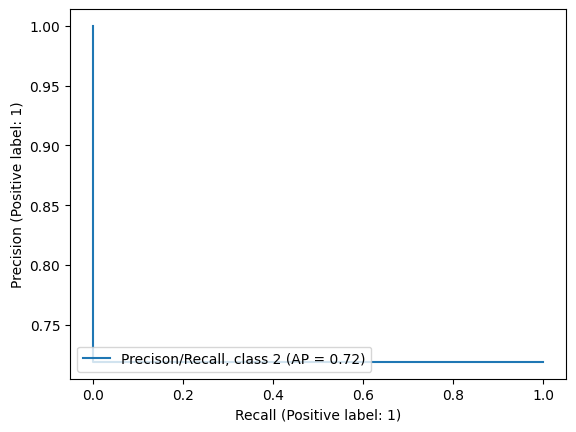

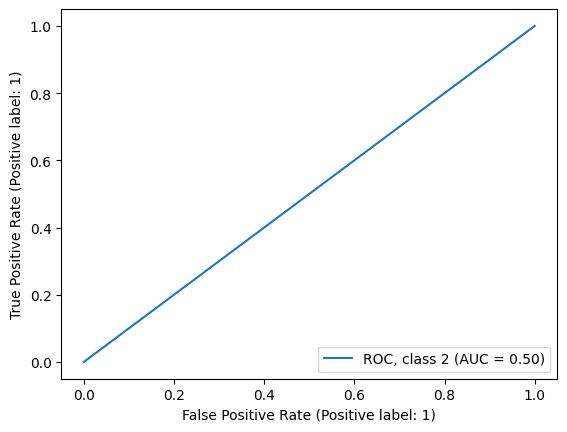

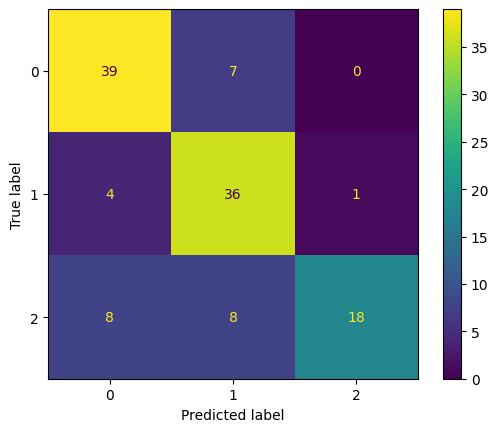

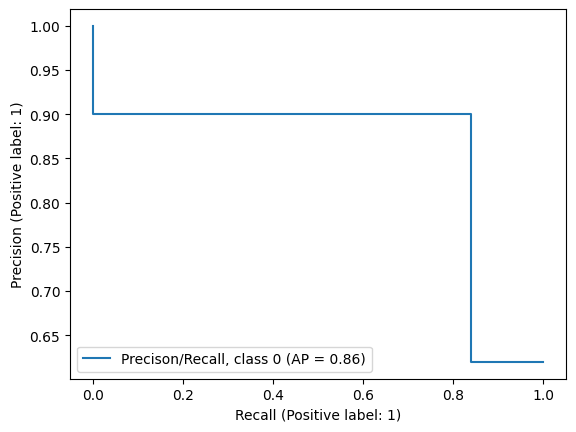

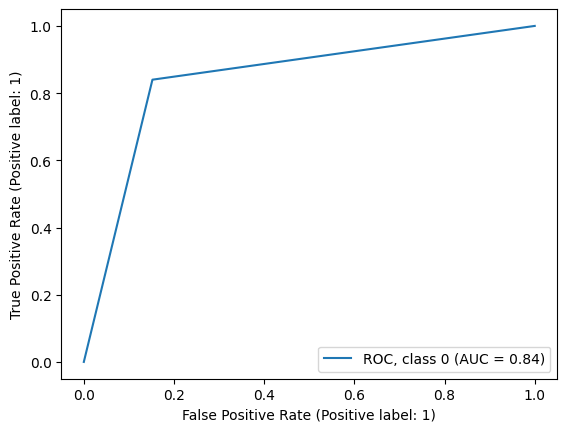

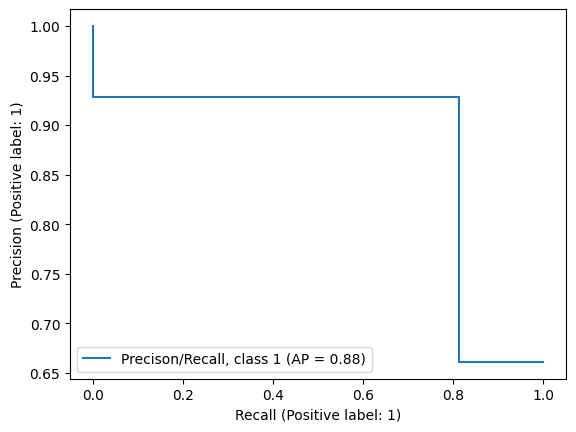

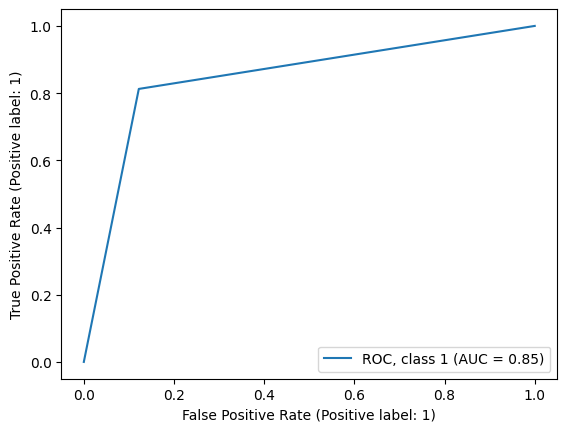

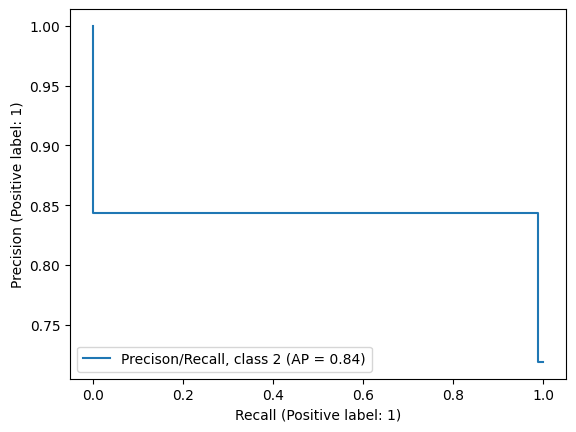

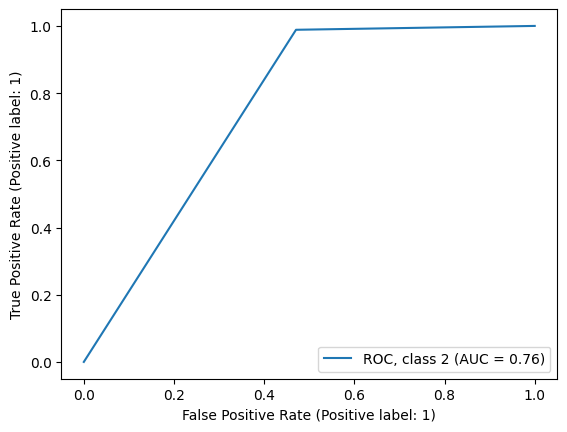

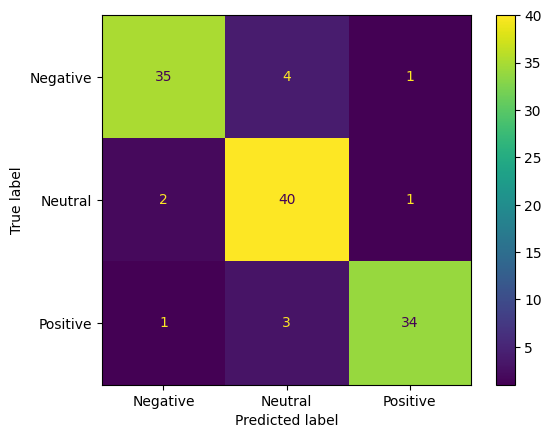

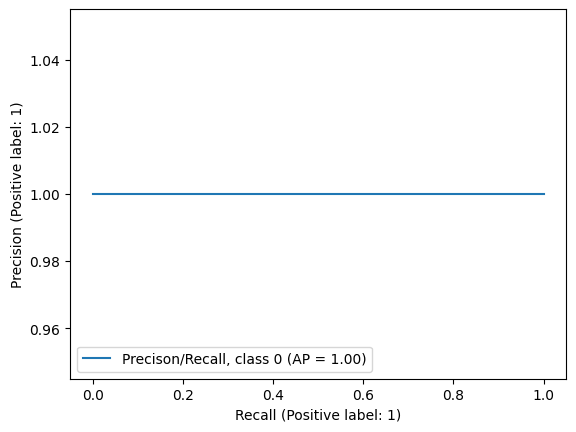

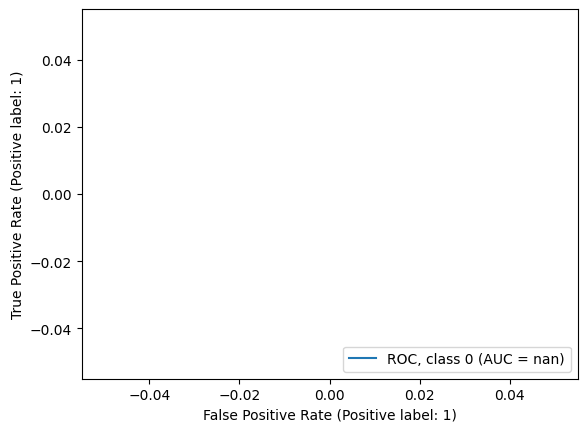

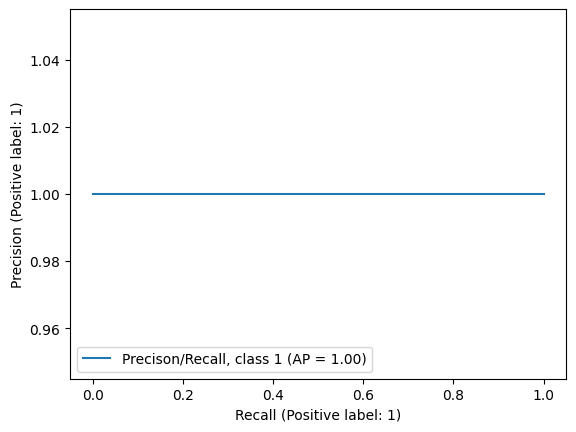

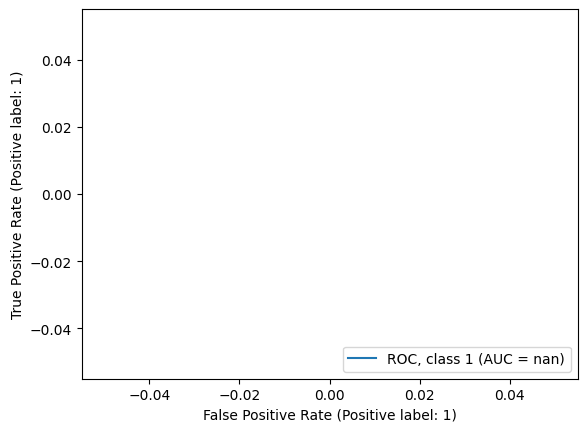

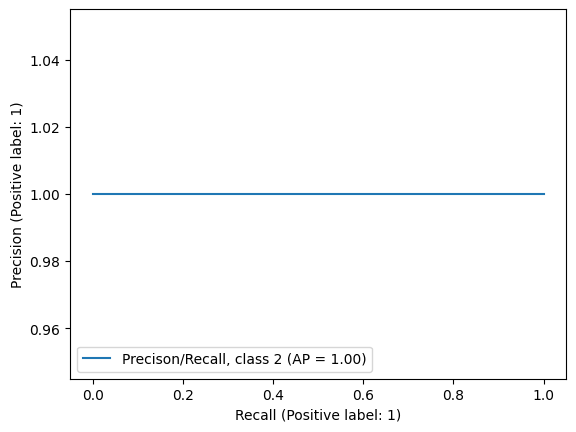

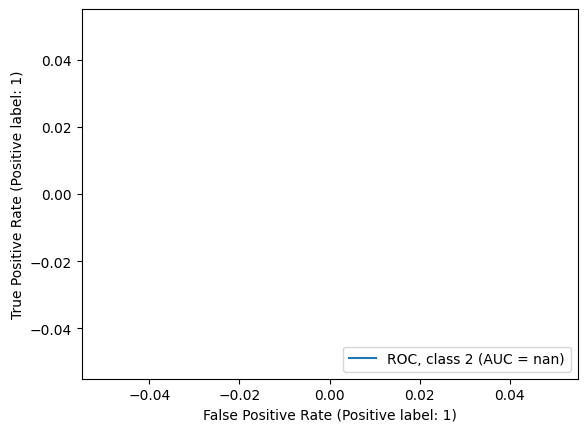

In [32]:
# convert text data into numerical features using CountVectorizer
X, y = vectorize_tamil_data()

## Ternary Model
# convert ratings into categorical labels: negative, neutral, and positive
neg_bound = 6
pos_bound = 8
y_categories_tertiary = y.copy()
for i in range(len(y_categories_tertiary)):
    if y_categories_tertiary[i] <= neg_bound:
        y_categories_tertiary[i] = 'Negative'
    elif neg_bound < y_categories_tertiary[i] <= pos_bound:
        y_categories_tertiary[i] = 'Neutral'
    elif y_categories_tertiary[i] > pos_bound:
        y_categories_tertiary[i] = 'Positive'

y_mini = tertiary_split(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)

print("Evaluating tertiary bayes model")
evaluate_model(y_test, X_test, tertiary_bayes_model)
print("Evaluating tertiary SVM model")
evaluate_model(y_test, X_test, tertiary_linear_svm_classifier)
print("Evaluating tertiary kNN model")
X_train, X_test, y_train, y_test = train_test_split(X, y_categories_tertiary, test_size=.20)
evaluate_model(y_test, X_test, knn_tertiary_model)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.



4/4 [==============================] - 7s 2s/step
              precision    recall  f1-score   support

           0       0.36      1.00      0.52        43
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        35

    accuracy                           0.36       121
   macro avg       0.12      0.33      0.17       121
weighted avg       0.13      0.36      0.19       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

model evaluation returned transient error


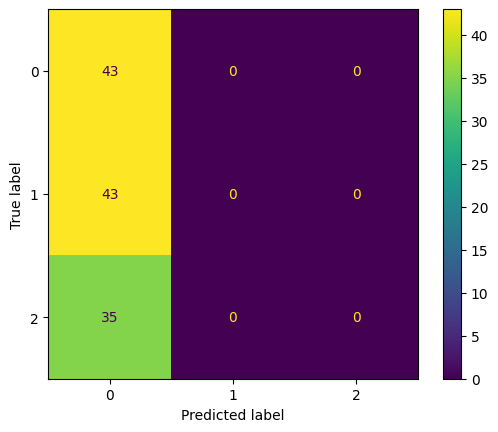

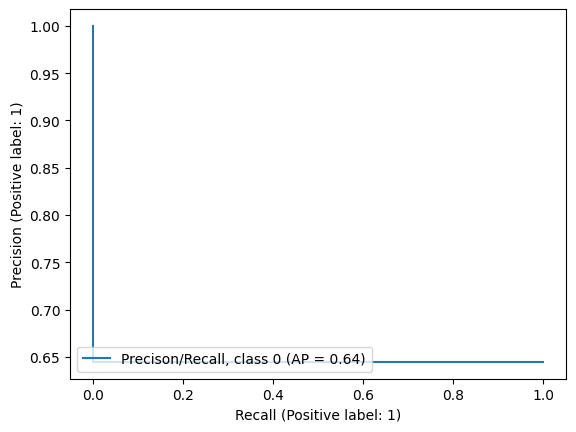

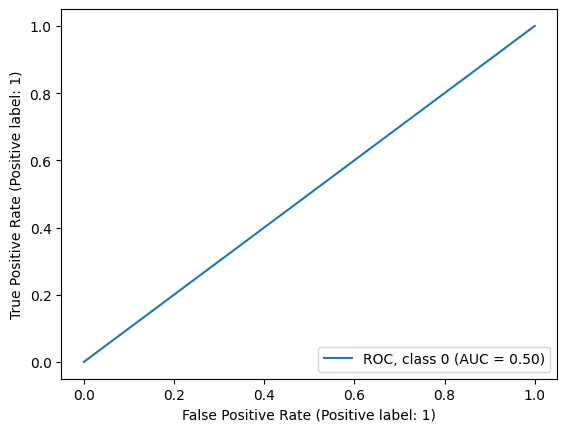

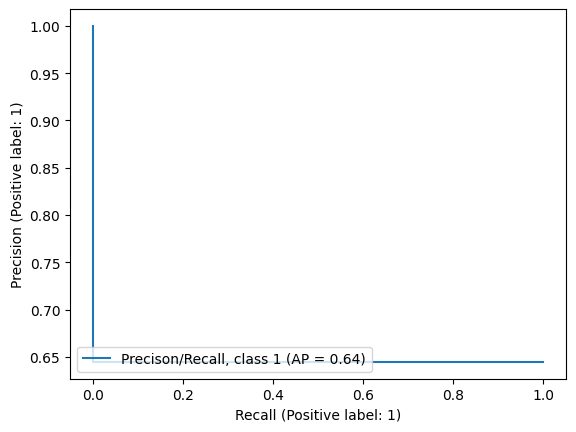

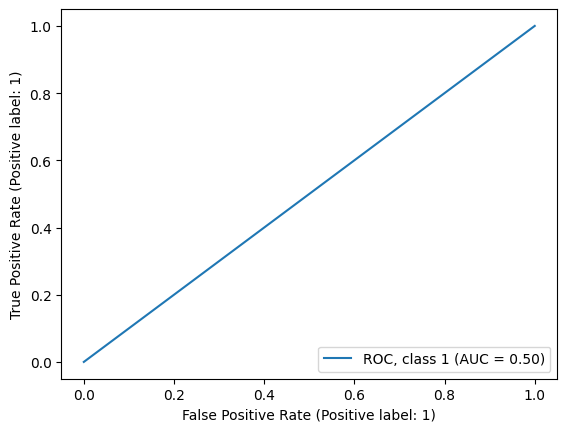

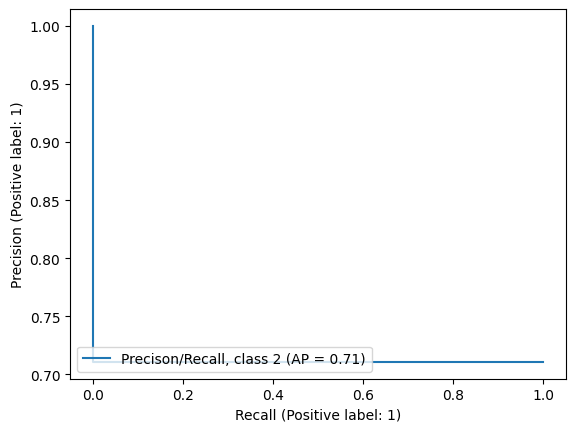

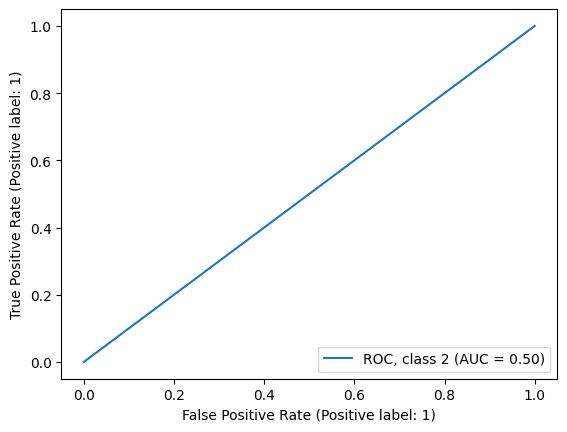

In [159]:
X, y = vectorize_tamil_data()
y_mini = tertiary_split(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
model = keras.models.load_model('/content/drive/My Drive/eece5644_final_project/tertiary_lstm_model.keras')

# This generates plots but throws an error if not all classes contain values
try:
    evaluate_model(y_test, X_test, model, True, dim=3)
except:
    print("model evaluation returned transient error")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.



4/4 [==============================] - 6s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.53      1.00      0.69        64

    accuracy                           0.53       121
   macro avg       0.26      0.50      0.35       121
weighted avg       0.28      0.53      0.37       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

model evaluation returned transient error


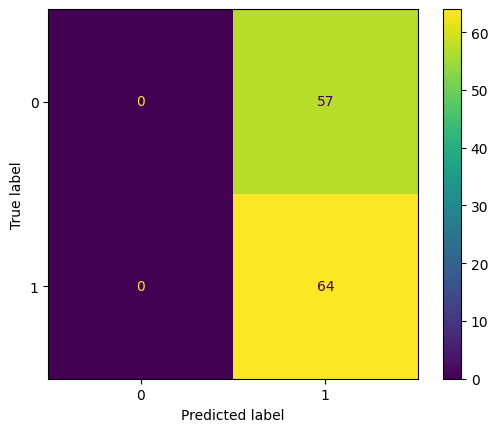

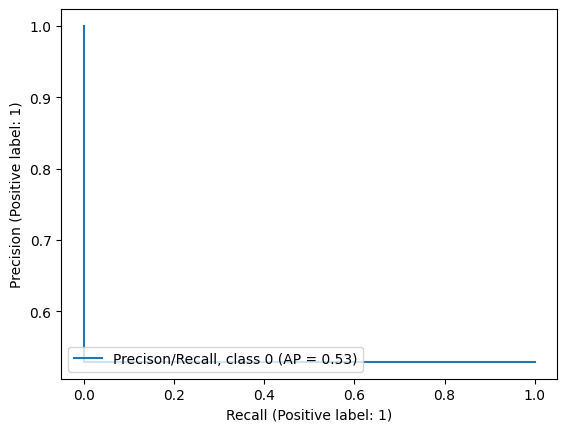

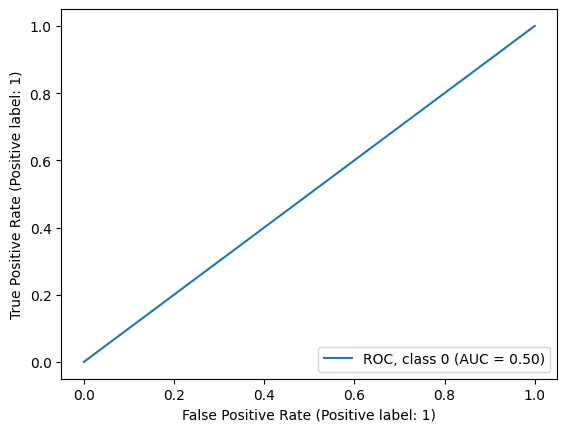

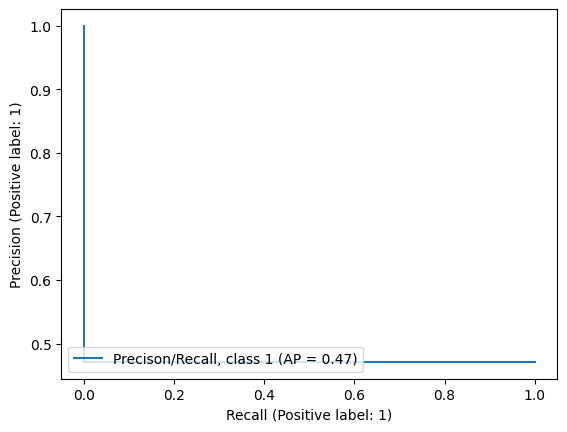

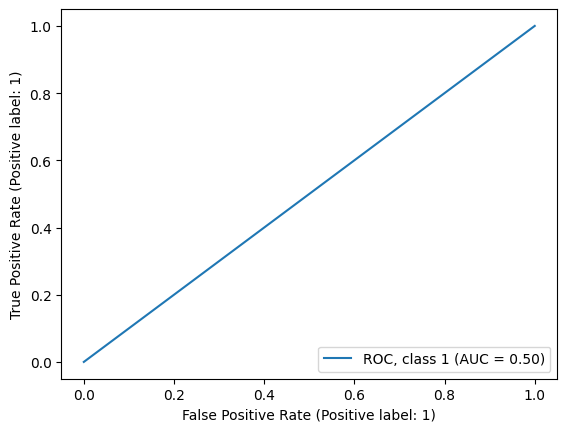

In [160]:
X, y = vectorize_tamil_data()
y_mini = binary_split(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)
model = keras.models.load_model('/content/drive/My Drive/eece5644_final_project/binary_lstm_model.keras')

# This generates plots but throws an error if not all classes contain values
try:
  evaluate_model(y_test, X_test, model, True, dim=2)
except:
    print("model evaluation returned transient error")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['அங', 'அட', 'அத', 'அதன', 'அதற', 'அந', 'அன', 'அல', 'அவ', 'அவன', 'அவர', 'அவரத', 'அவள', 'ஆக', 'இங', 'இடத', 'இடம', 'இத', 'இதன', 'இதற', 'இந', 'இன', 'இப', 'இர', 'இவ', 'இவர', 'உன', 'உள', 'எந', 'எனக', 'எனப', 'எனவ', 'எல', 'ஏன', 'ஒர', 'ஓர', 'கள', 'கவ', 'சற', 'தக', 'தத', 'தன', 'தனத', 'தப', 'தல', 'தவ', 'னர', 'பட', 'பத', 'பற', 'பலர', 'மட', 'மற', 'றக', 'லத', 'ளத', 'ளன', 'வந', 'வர'] not in stop_words.



Rating
Negative    313
Positive    288
Name: count, dtype: int64
Evaluating tertiary bayes model
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        62
           1       0.91      0.90      0.91        59

    accuracy                           0.91       121
   macro avg       0.91      0.91      0.91       121
weighted avg       0.91      0.91      0.91       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless



Evaluating tertiary SVM model
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        62
           1       0.86      0.86      0.86        59

    accuracy                           0.87       121
   macro avg       0.87      0.87      0.87       121
weighted avg       0.87      0.87      0.87       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless



Evaluating tertiary kNN model
              precision    recall  f1-score   support

    Negative       0.66      0.77      0.71        60
    Positive       0.73      0.61      0.66        61

    accuracy                           0.69       121
   macro avg       0.69      0.69      0.68       121
weighted avg       0.69      0.69      0.68       121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/roc_curve.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



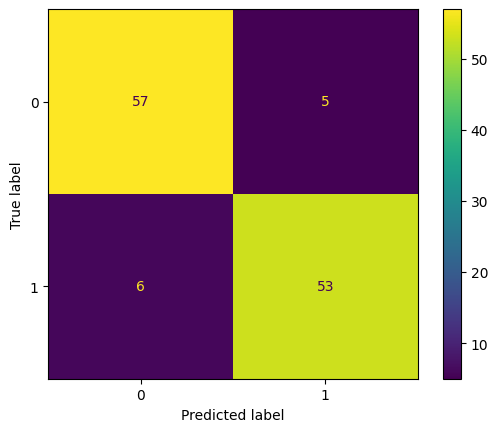

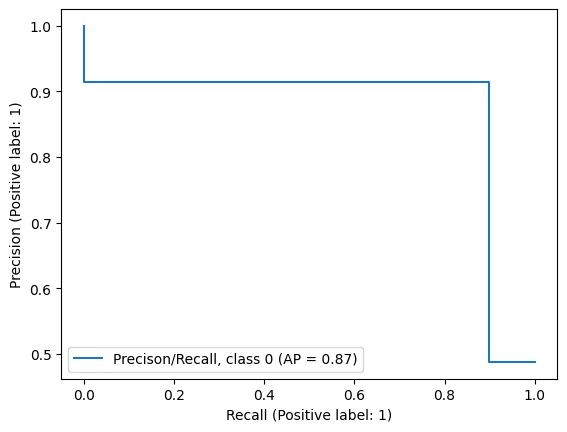

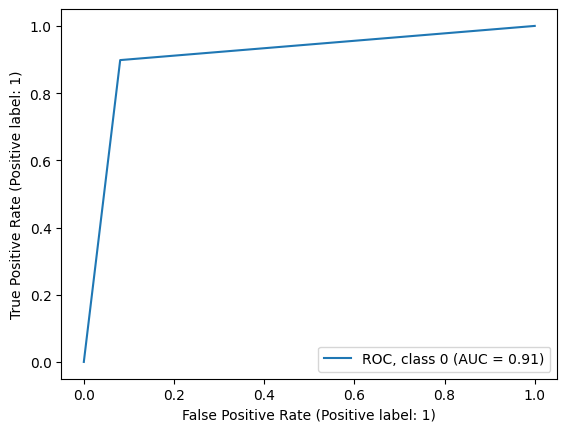

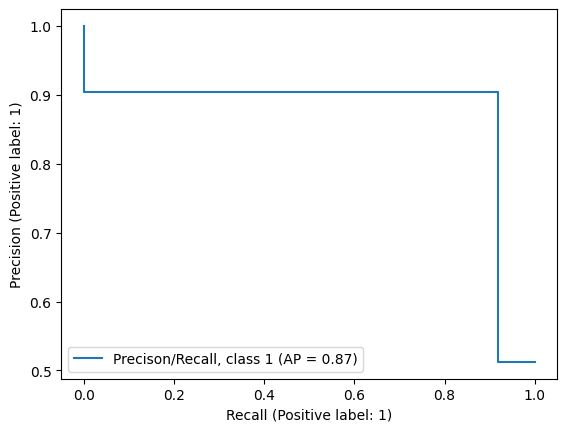

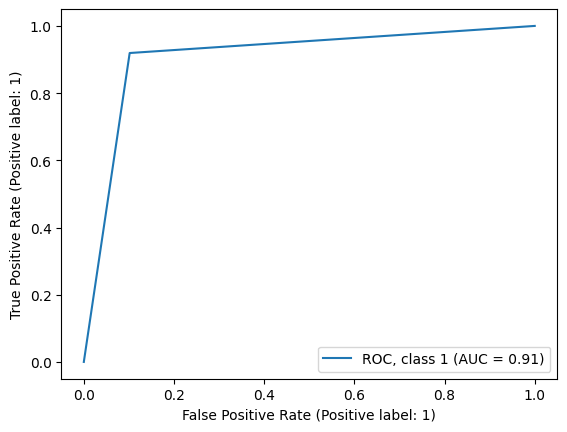

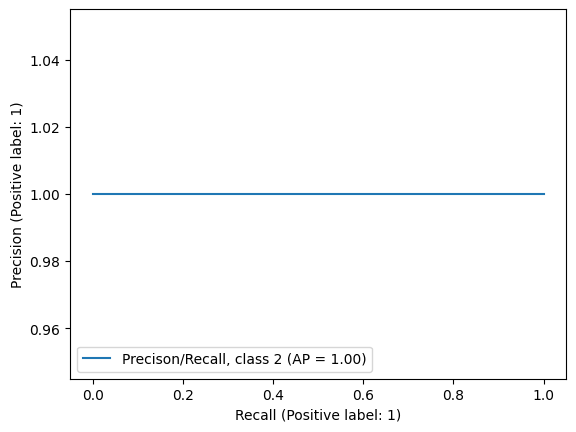

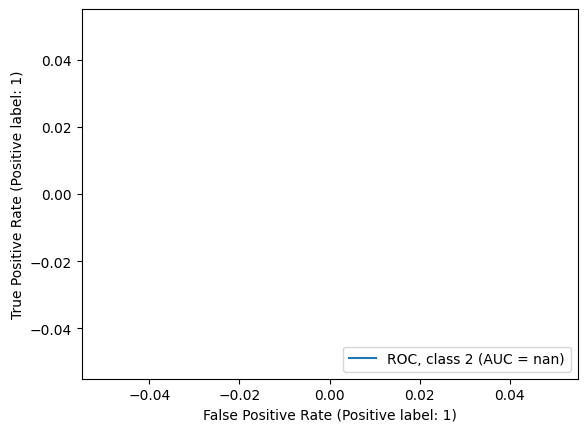

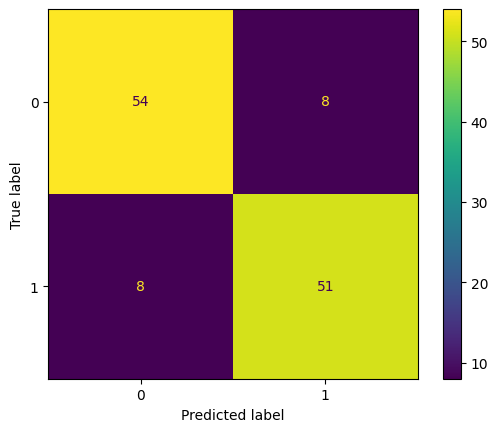

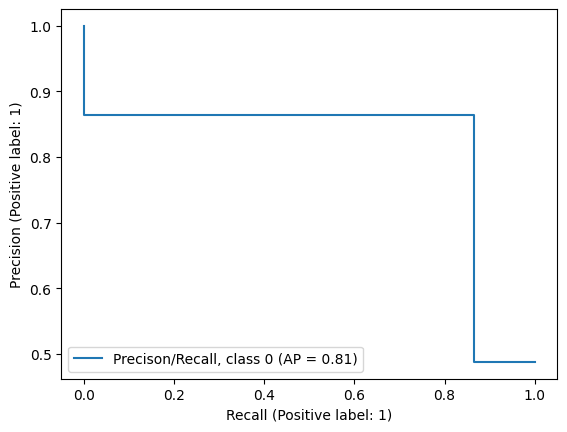

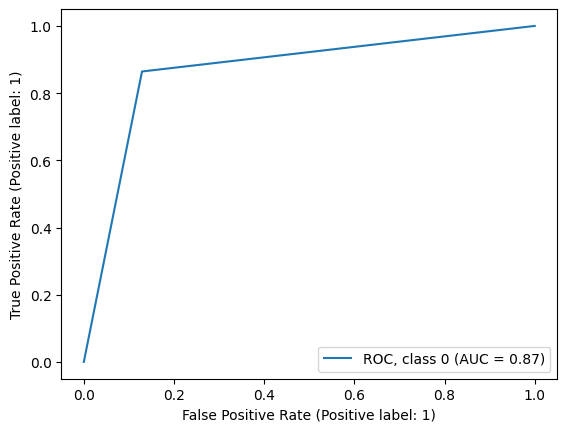

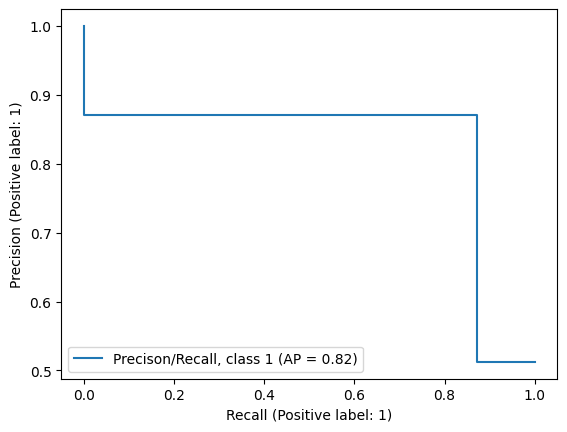

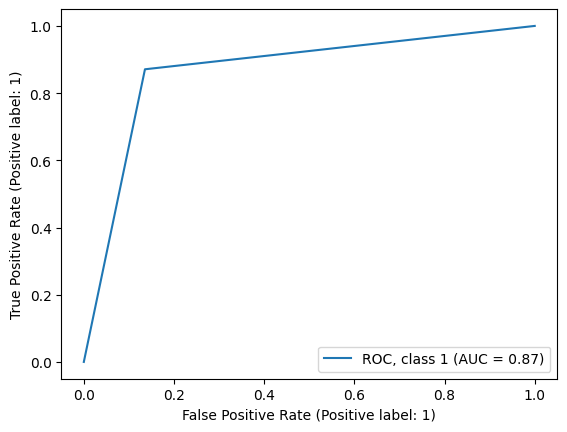

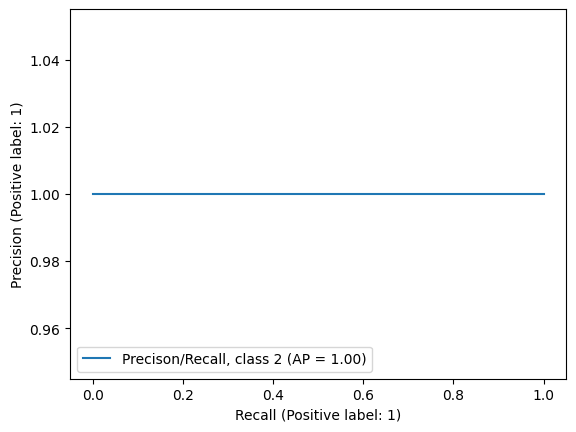

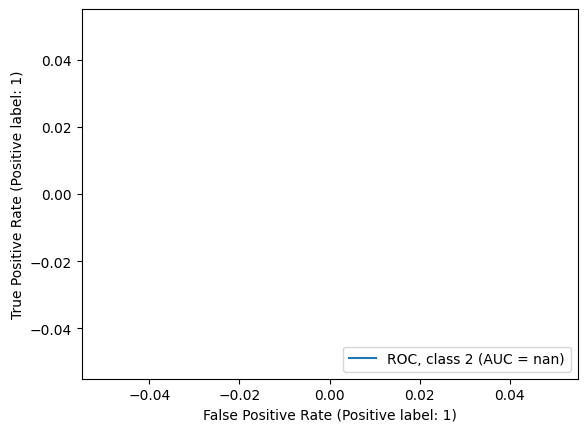

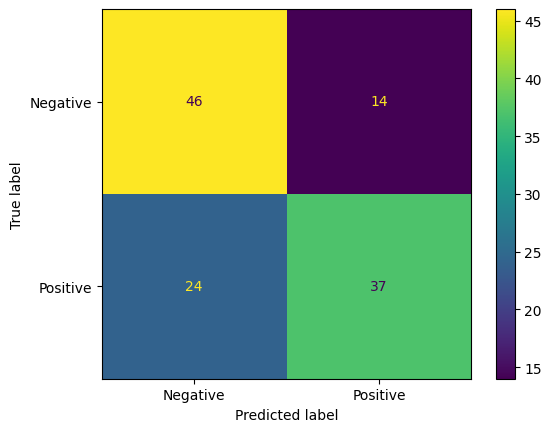

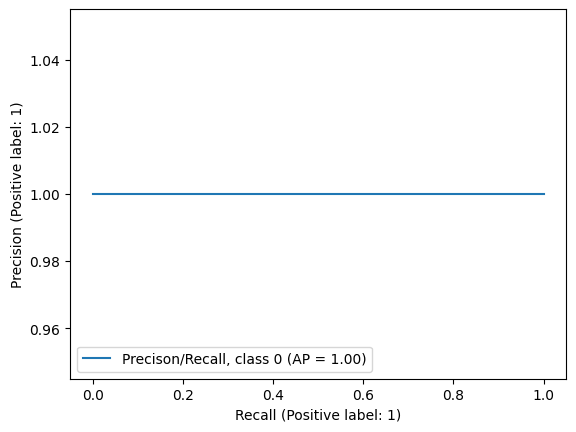

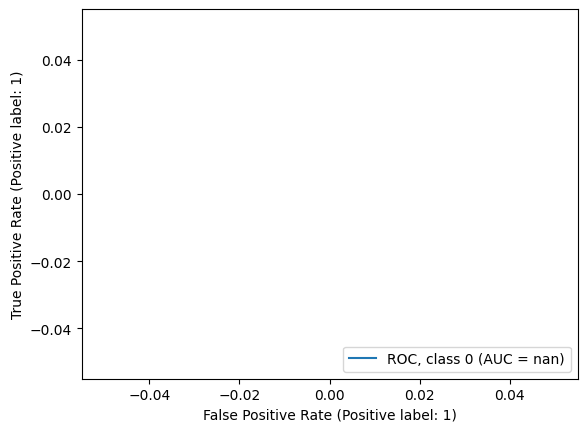

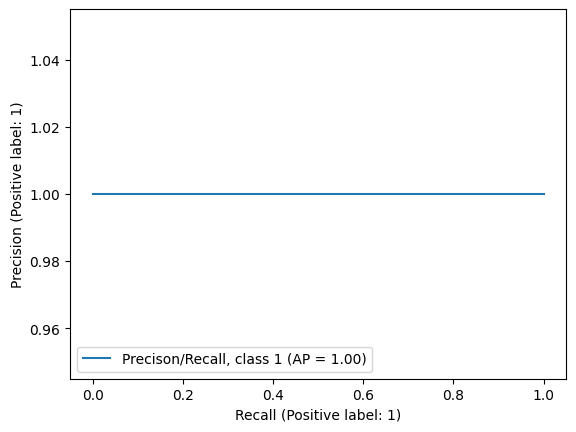

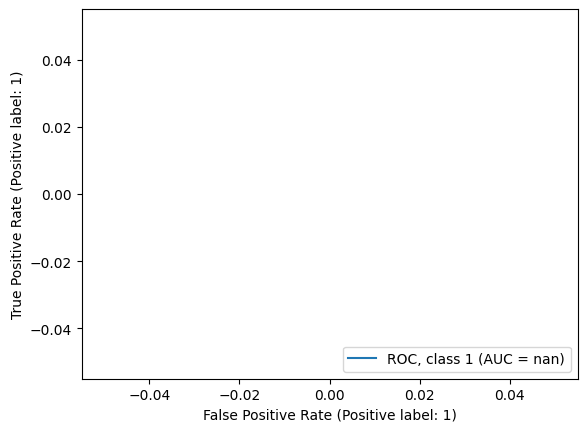

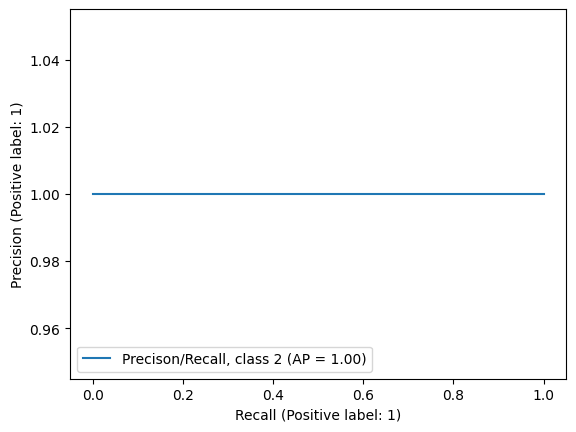

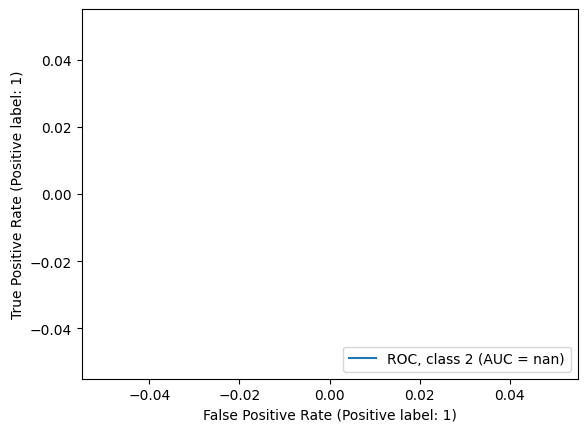

In [33]:
## Binary Model
# convert ratings into categorical labels: negative, neutral, and positive
X, y = vectorize_tamil_data()
y_mini = binary_split(y)

bound = 7
y_categories_binary = y.copy()
for i in range(len(y_categories_binary)):
    if y_categories_binary[i] <= bound:
        y_categories_binary[i] = 'Negative'
    elif y_categories_binary[i] > bound:
        y_categories_binary[i] = 'Positive'
print(y_categories_binary.value_counts())

y_mini = binary_split(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_mini, test_size=.20)


print("Evaluating tertiary bayes model")
evaluate_model(y_test, X_test, binary_bayes_model)
print("Evaluating tertiary SVM model")
evaluate_model(y_test, X_test, binary_linear_svm_classifier)
print("Evaluating tertiary kNN model")
X_train, X_test, y_train, y_test = train_test_split(X, y_categories_binary, test_size=.20)
evaluate_model(y_test, X_test, knn_binary_model)

In [24]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=max_features
)
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

model = keras.models.load_model('/content/drive/My Drive/eece5644_final_project/english_lstm_model.keras')

In [25]:
try:
  evaluate_model(y_test, x_test, model, True, dim=2)
except:
    print("model evaluation returned transient error")

4/4 [==============================] - 9s 2s/step
model evaluation returned transient error


In [ ]:
print("Evaluating binary bayes model (English)")
evaluate_model(y_test, x_test, english_bayes_model)
print("Evaluating binary SVM model (English)")
evaluate_model(y_test, x_test, english_svm_classifier)
print("Evaluating binary kNN model (English)")
evaluate_model(y_test, x_test, english_knn_classifier)

In [ ]:
# NOTE: K-Means evaluation section is contained within the "Cluster", and "K-Means | English" sections